In [44]:
from gene import Gene

import os
import shutil
import json
from pathlib import Path
from tqdm import trange
import numpy as np
import statistics
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from colabfold.batch import get_queries, run
from colabfold.download import default_data_dir
from colabfold.utils import setup_logging
from matplotlib import pyplot as plt

In [62]:

def clear_dir(filepath):
    for root, dirs, files in os.walk(filepath):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))

def save_proteins(genes, folder):
    os.mkdir(folder)
    for i, gene in enumerate(genes):
        protein = gene.get_protein()
        record = SeqRecord(protein, id=str(i), description=str(gene))
        filename = f'{folder}/gene{i}.fasta'
        gene.fasta = filename
        SeqIO.write(record, f'{folder}/gene{i}.fasta', 'fasta')
    
def fold(input_dir, result_dir, kwargs):
    setup_logging(Path(result_dir).joinpath("log.txt"))
    kwargs['queries'], kwargs['is_complex'] = get_queries(input_dir)
    kwargs['result_dir'] = result_dir
    results = run(**kwargs)
    return results

def calculate_fitnesses(genes, results):
    for gene, metric in zip(genes, results['metric']):
        mean_plddt, ptm = metric[0]['mean_plddt'], metric[0]['ptm']
        fitness = (mean_plddt / 100) * 0.5 + ptm * 0.5 + len(gene.get_protein()) * 0.01
        gene.fitness = fitness

def log_evolution(generations, logfile):
    with open(logfile, 'w') as f:
        data = [[gene.__dict__ for gene in gen] for gen in generations]
        json.dump(data, f)

def read_evolution(logfile):
    with open(logfile, 'r') as f:
        data = json.load(f)
        generations = [[Gene(**d) for d in gen] for gen in data]
    return generations

def plot_fitnesses(generations):
    fig = plt.figure()
    x = np.arange(len(generations))
    y = [np.mean([gene.fitness for gene in gen]) for gen in generations]
    yerr = [np.std([gene.fitness for gene in gen]) for gen in generations]
    plt.errorbar(x, y, yerr=yerr)
    plt.show()

In [69]:
n_genes = 10
n_bases = 50
n_generations = 10
proteins_path = 'proteins'
folds_path = 'folds'
logfile = 'log.txt'

colabfold_params = {
    'msa_mode': "single_sequence", #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
    'num_models': 1, #@param [1,2,3,4,5] {type:"raw"}
    'num_recycles': 3, #@param [1,3,6,12,24,48] {type:"raw"}
    'stop_at_score': 100, #@param {type:"string"}
    'num_relax': 0, #@param [0, 1, 5] {type:"raw"}
    'use_amber': False,
    'relax_max_iterations': 200, #@param [0,200,2000] {type:"raw"}
    'use_templates': False, #@param {type:"boolean"}
    'keep_existing_results': True, #@param {type:"boolean"}
    'zip_results': False, #@param {type:"boolean"}
    'model_type': "auto",
    'model_order': [1, 2, 3, 4, 5],
    'data_dir': default_data_dir,
    'keep_existing_results': True,
    'rank_by': "auto",
    'pair_mode': "unpaired+paired",
    'user_agent': "colabfold/google-colab-batch",
}

In [72]:
clear_dir(proteins_path)
clear_dir(folds_path)

In [ ]:
# first generation
generation = [Gene.generate(n_bases) for _ in range(n_genes)]
# filter empty proteins (begins with stop codon)
generation = [gene for gene in generation if len(gene.get_protein()) > 0]
save_proteins(generation, f'{proteins_path}/gen{0}')
results = fold(f'{proteins_path}/gen{0}', f'{folds_path}/gen{0}', colabfold_params)
calculate_fitnesses(generation, results)
generations = [generation]

# subsequent generations
for i in trange(1, n_generations+1):
    
    mutations = [gene.random_mutation() for gene in generation]
    # remove empty proteins
    mutations = [gene for gene in mutations if len(gene.get_protein()) > 0]

    # fold mutated proteins and calculate fitnesses as a batch
    save_proteins(mutations, f'{proteins_path}/gen{i}')
    results = fold(f'{proteins_path}/gen{i}', f'{folds_path}/gen{i}', colabfold_params)
    calculate_fitnesses(mutations, results)
    generation += mutations

    # stochastic selection
    fitnesses = [gene.fitness for gene in generation]
    generation = np.random.choice(generation, size=n_genes, replace=False, p=np.divide(fitnesses, sum(fitnesses))).tolist()
    generations.append(generation)

log_evolution(generations, logfile)

/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


2024-12-28 17:49:30,438 Running on GPU
2024-12-28 17:49:30,443 Found 2 citations for tools or databases
2024-12-28 17:49:30,443 Query 1/10: gene4 (length 1)
2024-12-28 17:49:33,999 Padding length to 11
2024-12-28 17:49:44,189 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=27 pTM=9.41e-05
2024-12-28 17:49:44,279 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=28.3 pTM=0.00013 tol=0.0001
2024-12-28 17:49:44,366 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=57.7 pTM=9.8e-05 tol=0.0001
2024-12-28 17:49:44,456 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=47.7 pTM=0.000107 tol=0.0001
2024-12-28 17:49:44,457 alphafold2_ptm_model_1_seed_000 took 10.5s (3 recycles)
2024-12-28 17:49:44,459 reranking models by 'plddt' metric
2024-12-28 17:49:44,459 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=47.7 pTM=0.000107
2024-12-28 17:49:44,784 Query 2/10: gene6 (length 1)
2024-12-28 17:49:45,979 Padding length to 11
2024-12-28 17:49:46,065 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=44.5 pTM=0.

/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


2024-12-28 17:50:09,907 Done


  0%|          | 0/10 [00:00<?, ?it/s]

2024-12-28 17:50:09,913 Running on GPU
2024-12-28 17:50:09,917 Found 2 citations for tools or databases
2024-12-28 17:50:09,919 Query 1/10: gene1 (length 4)


In [66]:
generations = read_evolution(logfile)

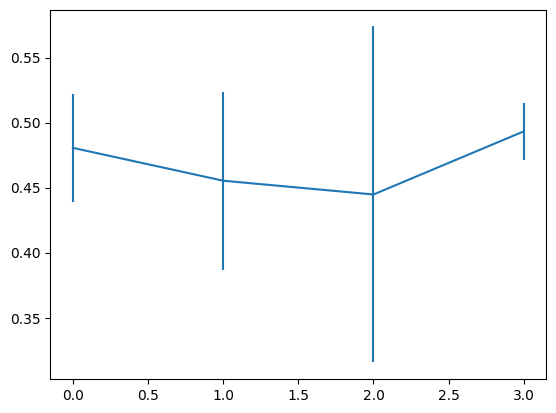

In [67]:
plot_fitnesses(generations)